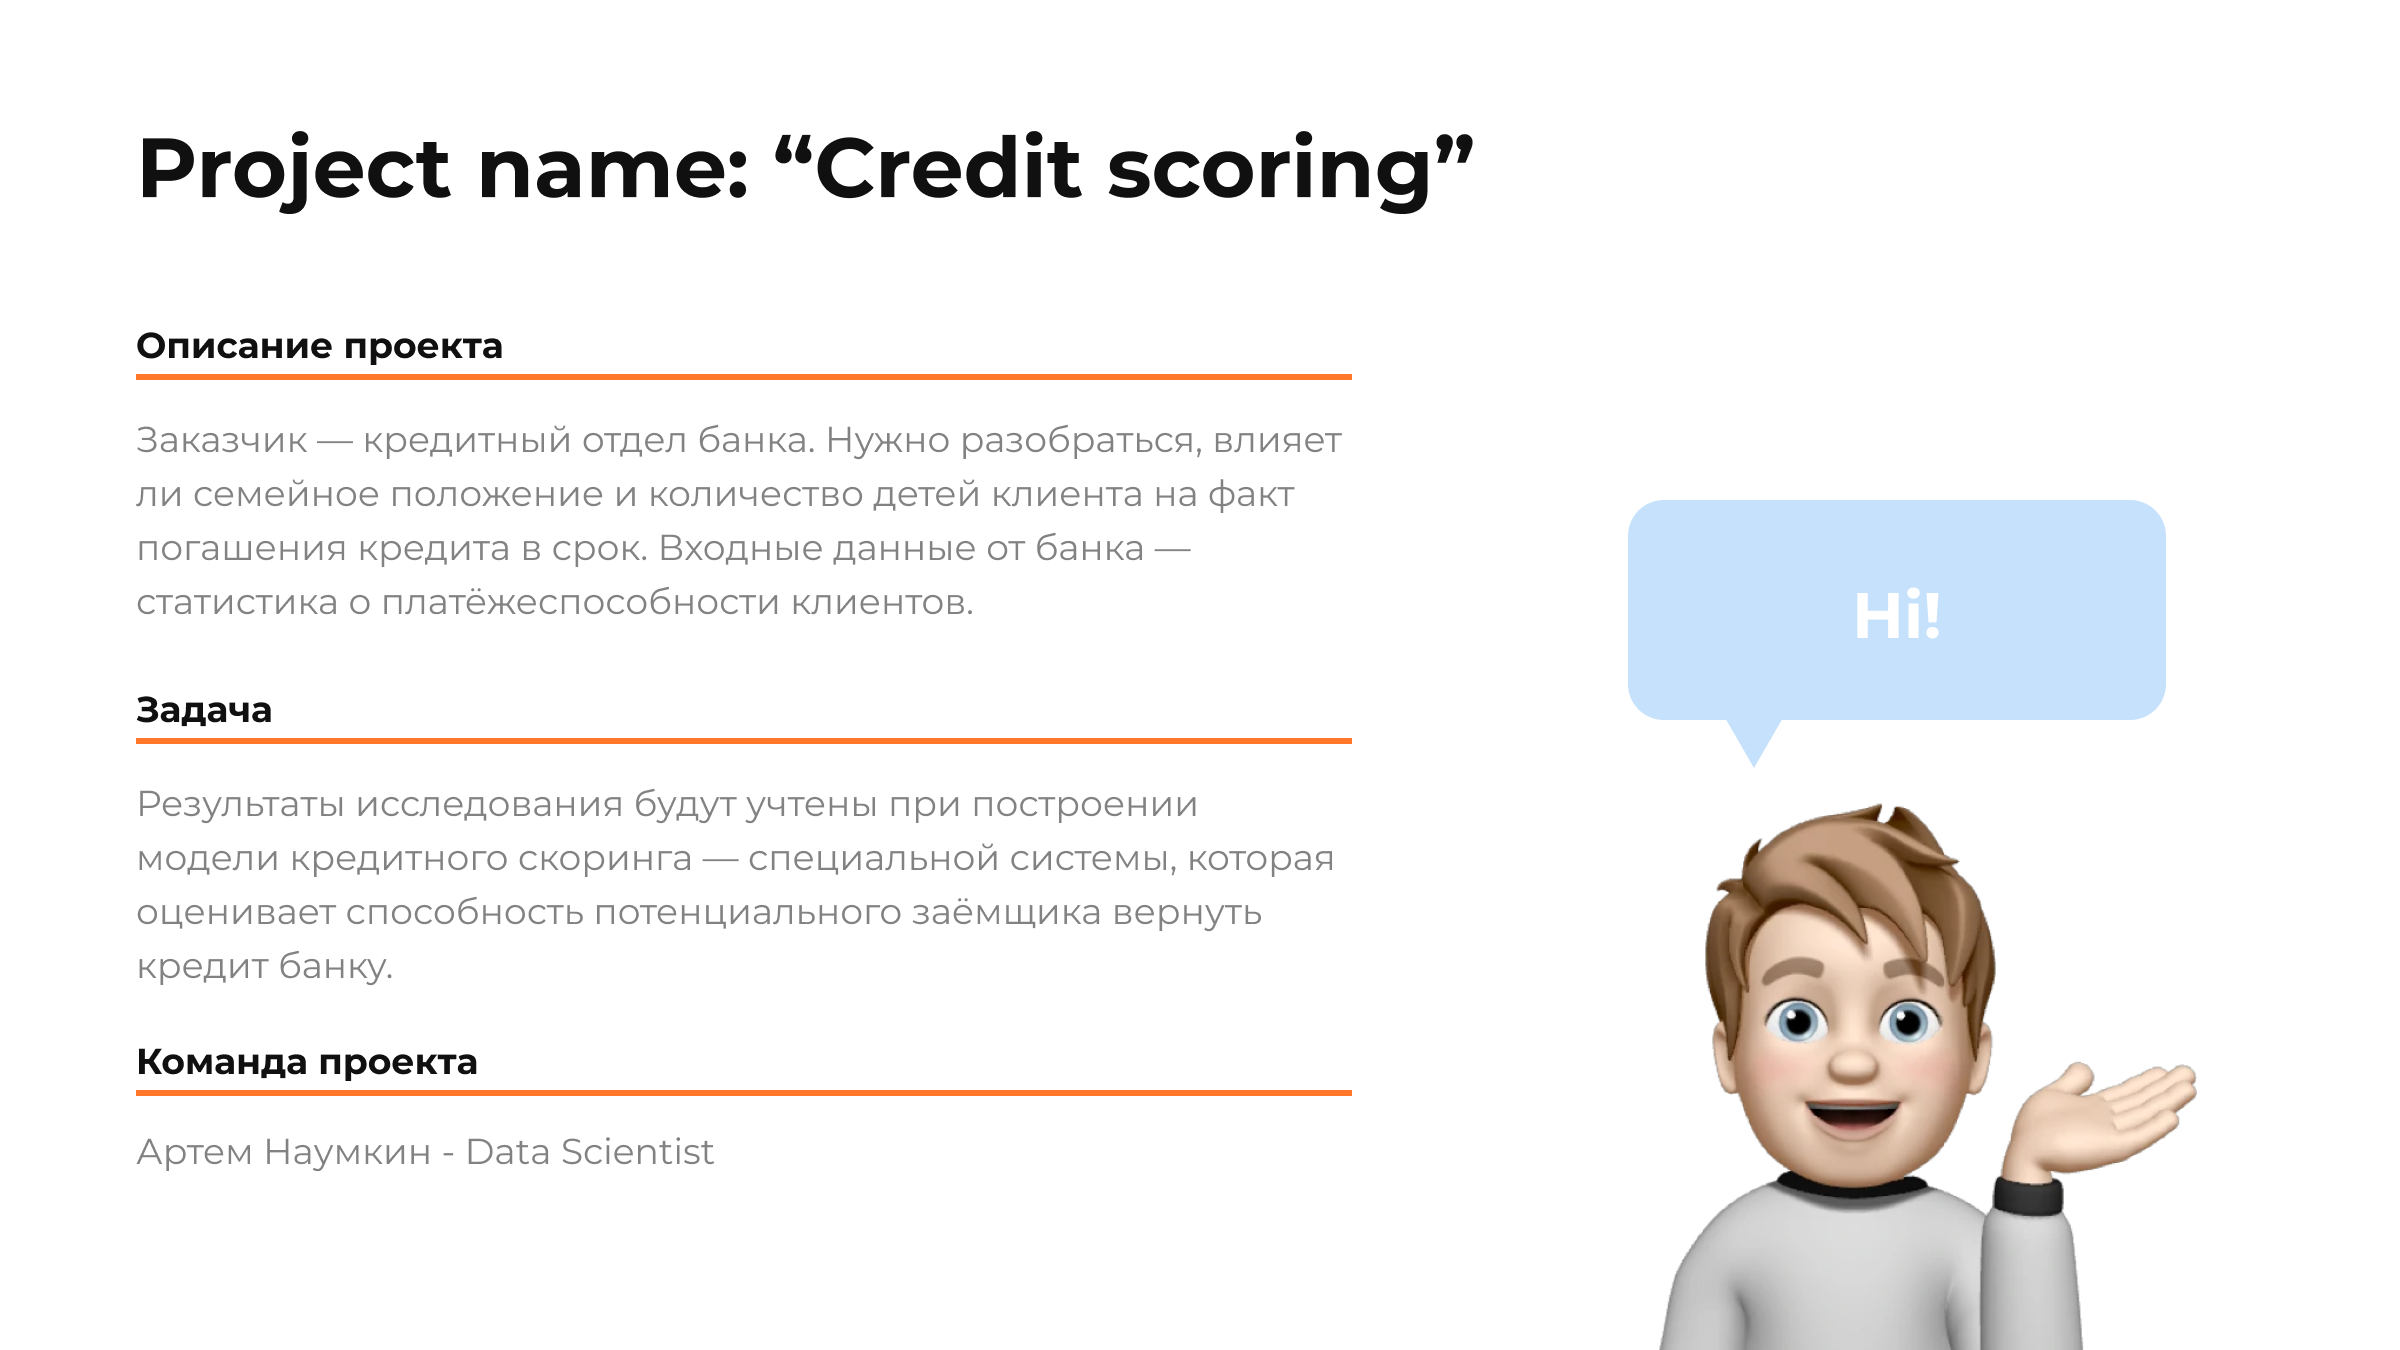

# Исследование надежности заемщиков


Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Откройте таблицу и изучите общую информацию о данных

In [1]:
import pandas as pd
import numpy as np

try:
    data = pd.read_csv('project_2.csv')
except:
    data = pd.read_csv('https://yandex.ru/datasets/data.csv')

In [2]:
data.head(10)

,Unnamed: 0,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        21525 non-null  int64  
 1   children          21525 non-null  int64  
 2   days_employed     19351 non-null  float64
 3   dob_years         21525 non-null  int64  
 4   education         21525 non-null  object 
 5   education_id      21525 non-null  int64  
 6   family_status     21525 non-null  object 
 7   family_status_id  21525 non-null  int64  
 8   gender            21525 non-null  object 
 9   income_type       21525 non-null  object 
 10  debt              21525 non-null  int64  
 11  total_income      19351 non-null  float64
 12  purpose           21525 non-null  object 
dtypes: float64(2), int64(6), object(5)
memory usage: 2.1+ MB


## Предобработка данных

### Удаление пропусков

In [4]:
data.isna().sum()

Unnamed: 0             0
children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [5]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

In [6]:
data['days_employed'] = data['days_employed'].abs()

In [7]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

In [8]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

In [9]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [10]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

### Удаление пропусков (продолжение)

In [11]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [12]:
data.isna().sum()

Unnamed: 0          0
children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

In [13]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

In [14]:
data['education'] = data['education'].str.lower()

In [15]:
data.duplicated().sum()

0

In [16]:
data = data.drop_duplicates()

### Категоризация данных

**Категории с доходами:**

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.



In [17]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [18]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

In [19]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [20]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [21]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

### Шаг 3. Исследуйте данные и ответьте на вопросы

#### 3.1 Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [22]:
data.groupby('children')['debt'].agg(['count','sum','mean'])

,count,sum,mean
children,,,
0,14149,1063,0.075129
1,4818,444,0.092154
2,2055,194,0.094404
3,330,27,0.081818
4,41,4,0.097561
5,9,0,0.000000


**Вывод:**  Клиенты с детьми менее надежные заемщики, чем без детей. Люди с тремя детьми - статистически чаще отдают кредиты, чем с двумя, тремя и даже с 4 детьми. Люди без детей в меньшей степени имеют какие-либо кредитные задолженности. Людей с пятью детьми не хватает для правильной оценки. Люди с четырями детьми чаще других имеют задолженности.

#### 3.2 Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [23]:
family_and_debt = data.pivot_table(columns='family_status', values='debt', aggfunc='mean')
display(family_and_debt)

family_status,Не женат / не замужем,в разводе,вдовец / вдова,гражданский брак,женат / замужем
debt,0.097535,0.070648,0.066176,0.092548,0.075354


**Вывод:** Неженатые и незамужние, а также люди находящихся в гражданском браке, чаще имеют задолженность по сравнению с другими людьми, которые имеют другие семейные статусы: в разводе, вдовцы, женатые и замужние. Вдовцы и вдовы реже имеют какие-либо кредитные задолженности, а люди не состоявшие никогда в браке чаще других.  

#### 3.3 Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

- 0 – 30 000 — `'E'`;
- 30 001 – 50 000 — `'D'`;
- 50 001 – 200 000 — `'C'`;
- 200 001 – 1 000 000 — `'B'`;
- 1 000 001 и выше — `'A'`.

In [24]:
income_and_debt = data.pivot_table(columns=['total_income_category'], values='debt', aggfunc='mean')
display(income_and_debt)

total_income_category,A,B,C,D,E
debt,0.08,0.070602,0.084605,0.060172,0.090909


**Вывод:** Люди с доходом менее 30 000₽, чаще других имеют задолженность. Люди с доходом от 30 000₽ до 50 000₽ в меньшей степени склонны не оплачивать во время кредиты. Прямой зависимости от суммы дохода к задолженности по кредитам - нет. Т.е. нет такого, что человек чем больше зарабатывает, тем он более вероятнее будет вовремя платить по кредиту. Люди с доходом более 1 000 000₽ чаще имеют задолженности, чем люди с доходом меньше, кроме людей с доходом от 50 000₽ до 200 000₽.

#### 3.4 Как разные цели кредита влияют на его возврат в срок?

In [25]:
purpose_and_debt = data.pivot_table(columns=['purpose_category'], values='debt', aggfunc='mean')
display(purpose_and_debt)

purpose_category,операции с автомобилем,операции с недвижимостью,получение образования,проведение свадьбы
debt,0.093284,0.072356,0.092319,0.078306


**Вывод:** Люди указавшие в целях приобретения кредита операции с недвижимостью или для свадьбы в меньшей степени имеют задолженности. Бравшие кредит на недвижимость чаще не имеют задолженности. Вероятнее всего из-за цен на недвижимость, люди в меньшей степени здесь склонны к импульсивным покупкам и рассчитывают свой бюджет.  
Те кто выбирают операции с автомобилем и получением образования - чаще других групп имеют задолженности.

### Шаг 4: общий вывод.

**Зависимость между количеством детей и возвратом кредита в срок.**


|Количество детей |Процент должников (%)|
| ------:|----   |
|0   | 7.543822|
|1   |9.234609 |
|2   | 9.454191|
|3   |8.181818 |
|4   |9.756098 |
|5   |0.000000 |


>Самые надежные клиенты - это люди не имеющие детей: ~7,5% имели задолженности по кредиту.
Клиенты с тремя детьми - занимают второе место: ~8,2% невозврата в срок.
Самые ненадежные клиенты - это люди с четыремя детьми: 9,7% имели задолженности.  

**Зависимость между семейным положением и возвратом кредита в срок.**

|Семейное положение |Процент должников (%)|
|-----:|----:    |
|Не женат / не замужем   | 9.763948|
|В разводе               | 7.064760|
|Вдовец / вдова          | 6.624606|
|Гражданский брак        |9.313014|
|Женат / замужем         | 7.560558|

>Самые надежные клиенты - овдовевшие люди: ~6,7% имели задолженности по кредиту.
Клиенты в разводе - занимают второе место: ~7,1% невозврата в срок.
Самые ненадежные клиенты - это люди не вступавшие в брак: ~9,8% имели задолженности.

**Зависимость между уровнем дохода и возвратом кредита в срок.**

|Уровни дохода|Доходы (₽)|Процент должников (%)|
|------:|----:    |----:    |
|A | 1 000 001 и выше   | 8.000000|
|B            | 200 001 – 1 000 000 | 7.060231|
|C        | 50 001 – 200 000 | 8.498210|
|D     | 30 001 – 50 000 |6.017192|
|E        | 0 – 30 000| 9.090909|

>Самые надежные клиенты - люди с доходом от 30 000₽ до 50 000₽: ~6% имели задолженности по кредиту.
Клиенты с доходам от 200 000₽ - 1 000 000₽ - занимают второе место: ~7% невозврата в срок.
Самые ненадежные клиенты - это люди с доходам менее 30 000₽: ~9,1% имели задолженности.

**Зависимость разные цели кредита влияют на возврат кредита в срок.**

|Категории операций  |Процент должников (%)|
|------:|----:    |
|Операции с автомобилем   |   9.347978|
|Операции с недвижимостью |   7.255139|
|Получение образования    |   9.252758|
|Проведение свадьбы       |   7.911803|

>Самые надежные клиенты - люди берущие кредит на операции с недвижимостью: ~7,3% имели задолженности по кредиту.
Клиенты которые берут кредит для свадьбы - занимают второе место: ~7,9% невозврата в срок.
Самые ненадежные клиенты - это люди берущие кредит на автомобиль: ~9,3% имели задолженности.